<a href="https://colab.research.google.com/github/oscarld-dl/ML-Workshop/blob/main/Predictive_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

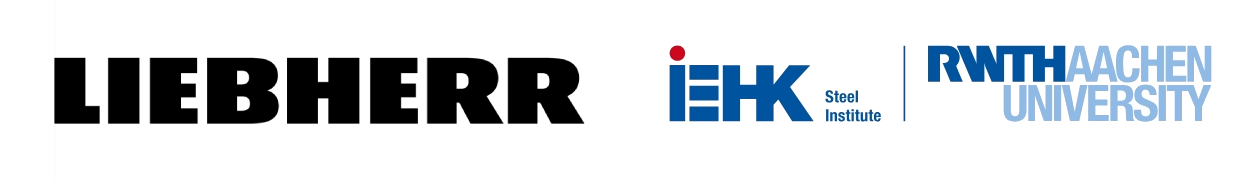

In [1]:
from IPython.display import Image, display
display(Image("head.jpg"))

# ML Workshop

RWTH Aachen University, 07.10.2025




***************************************************************************************************************************
**The goal of this workshop is to understand how we have developed the descriptive and predictive analyses using ML/DL tools.**
***************************************************************************************************************************

**Tasks for the Predictive Analysis:**
-------------

1. Understanding **K-Fold Cross-Validation**.
2. Using **scikit.learn** to evaluate different **linear regression models**.
3. Upgrading to **stacked regression models** to improve accuracy.
4. Using the best performing model to **generate the outputs of new synthetic inputs** (after data augmentation)

**Import basic libraries again:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Import specific libraries:**

[Visit scikit-learn webpage HERE for more information](https://scikit-learn.org/stable/)

In [ ]:
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, Lars, LassoLars, LassoLarsIC, BayesianRidge, MultiTaskLasso, MultiTaskLassoCV, HuberRegressor, ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

**Understanding the Cross-Validation:**

<img src="https://github.com/oscarld-dl/ML-Workshop/blob/main/cv.jpg?raw=1" alt="Header Image" width="1000"/>

1. Dataset is split into K subsets.
2. The algorithm is then iterated K (fold) times and in each fold different subsets are used as a validation set (green ones)
3. This help us to determine the model's sensitivity to new and unseen data.
4. Finally a holdout/test set is used to evaluate the model.

**Let's gather different models from the library**

1. Why normalization.
2. Why splitting the data.

**Hands-on**

1. Add base models. Take just the most important ones but GB at the beginning.
2. Try different K folders to see how it takes more computational time to solve. Also to check how accuracy changes.

In [ ]:
# Load the Excel file again
df_experimental = pd.read_excel("D:/THESIS/OUTPUTS/master.xlsx", sheet_name="experimental")

# Input and output split
X = df_experimental.iloc[:89, 1:12]
print(X)
Y = df_experimental.iloc[:89, 12:]

# Normalize inputs and outputs
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=18, random_state=42, shuffle=False)

# Define models to test
base_models = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Ridge": Ridge(),
    "RidgeCV": RidgeCV(),
    "Lasso": Lasso(),
    "LassoCV": LassoCV(),
    "Lars": Lars(),
    "ElasticNet": ElasticNet(),
    "ElasticNetCV": ElasticNetCV(),
    "LassoLars": LassoLars(),
    "LassoLarsIC": LassoLarsIC(),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "SVR (RBF Kernel)": SVR(kernel='rbf'),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(200, 100), activation='relu', solver='lbfgs', max_iter=3500, random_state=42)
}


results_per_model = {}
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)  # Reduce repeats for speed if needed

for name, model in base_models.items():
    print(f"Evaluating {name}...")
    multi_model = MultiOutputRegressor(model)
    r2_scores = []

    for train_idx, test_idx in rkf.split(X_scaled):
        X_train, X_val = X_scaled[train_idx], X_scaled[test_idx]
        Y_train, Y_val = Y_scaled[train_idx], Y_scaled[test_idx]

        multi_model.fit(X_train, Y_train)
        Y_pred = multi_model.predict(X_val)

        fold_r2 = r2_score(Y_val, Y_pred, multioutput='raw_values')  # List of R² for each output
        r2_scores.append(fold_r2)

    # Average R² per output
    r2_scores = np.array(r2_scores)
    avg_r2_per_output = np.mean(r2_scores, axis=0)
    results_per_model[name] = avg_r2_per_output

results_df = pd.DataFrame(results_per_model, index=Y.columns).T  # Models as rows, outputs as columns
results_df["Average R² Score"] = results_df.mean(axis=1)

# Sort
results_df.sort_values(by="Average R² Score", ascending=False, inplace=True)

# Save
#results_df.to_csv("D:/THESIS/OUTPUTS/model_performance_detailed_CV.csv", index=True)
print(results_df)

In [ ]:
from itertools import combinations
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import r2_score, make_scorer

def multioutput_r2_score(y_true, y_pred):
    return np.mean([r2_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

scorer = make_scorer(multioutput_r2_score, greater_is_better=True)

# Load the dataset
df = pd.read_excel("D:/THESIS/OUTPUTS/master.xlsx", sheet_name="experimental")

# Input and output split
X = df.iloc[1:89, 1:12]
Y = df.iloc[1:89, 12:]

# Normalize inputs and outputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=18, random_state=0)

# Define candidate base models
candidate_models = {
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(200, 100), activation='relu', solver='lbfgs', max_iter=3550, random_state=0),
    'Gradient Boosting': GradientBoostingRegressor(),
    'RF': RandomForestRegressor()
}

meta_model = SVR()

#Store results
stacking_results = []
rkf = RepeatedKFold(n_splits=5, n_repeats=100, random_state=42)

# Try all pairwise combinations of base models
for combo in combinations(candidate_models.items(), 2):
    name_combo = ' + '.join([combo[0][0], combo[1][0]])
    base_learners = [(combo[0][0], combo[0][1]), (combo[1][0], combo[1][1])]

    stacked_model = StackingRegressor(estimators=base_learners, final_estimator=meta_model)
    multi_model = MultiOutputRegressor(stacked_model)
    scores = cross_val_score(multi_model, X_scaled, Y_scaled, cv=rkf, scoring=scorer)
    avg_score = np.mean(scores)
    stacking_results.append((name_combo, avg_score))

# Print sorted results
stacking_results_df = pd.DataFrame(stacking_results, columns=["Model", "Average R² Score"])
stacking_results_df.sort_values(by="Average R² Score", ascending=False, inplace=True)
print(stacking_results_df)

**Data Augmentation**

In [ ]:
#1000 DESIGNS

import pandas as pd
import os
import random

output_file = r"D:\THESIS\OUTPUTS\Generator.xlsx"
num_designs = 20000 # Target number of random combinations

# Define synthetic value ranges for each parameter
synthetic_values = {
    "C": [0.0014, 0.0015, 0.0016, 0.0017, 0.0018, 0.0019, 0.0020],
    "$H_{T1}$": [880, 890, 900, 910, 920, 930, 940],
    "$H_{T2}$": [790, 800, 810, 820, 830, 840, 850],
    "P": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "d": [0.0335, 0.0435, 0.0535, 0.0635, 0.0735, 0.0835, 0.0935],
    "alpha": [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90],
    "Pearlite": [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50],
    "$Cryo_{T}$": [-75, -80, -90, -100, -110, -120, -125],
    "$Cryo_{t}$": [2400, 2800, 3200, 3600, 3900, 4500, 4800],
    "$Temper_{T}$": [150, 160, 170, 185, 200, 225, 250],
    "Temper_{t}": [3600, 4200, 4800, 5400, 6000, 6600, 7200]
}

# Generate random combinations
random_combinations = []
for _ in range(num_designs):
    combination = {param: random.choice(values) for param, values in synthetic_values.items()}
    if combination["alpha"] + combination["Pearlite"] == 1:
            random_combinations.append(combination)

# Create DataFrame
synthetic_df = pd.DataFrame(random_combinations)

# Append to existing file or create new
if os.path.exists(output_file):
    existing_df = pd.read_excel(output_file)
    df_combined = pd.concat([existing_df, synthetic_df], ignore_index=True)
else:
    df_combined = synthetic_df

df_combined.to_excel(output_file, index=False, engine='openpyxl')
print(f"Generated {len(synthetic_df)} random designs. Data saved to {output_file}")

**GB model as the output generator for synthetic input data.**

1. Explain here the other way to split the data using **train_test_split**

In [ ]:
# Loading real data for training
df_real = pd.read_excel("D:/THESIS/OUTPUTS/master.xlsx", sheet_name="experimental")
X= df_real.iloc[:88, 1:12]
Y= df_real.iloc[:88, 12:]

scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=18, random_state=42, shuffle=False)


# Loading synthetic data for the 1000 predicted outputs
df_synthetic_1000=pd.read_excel("D:/THESIS/OUTPUTS/DoEs_1000.xlsx").iloc[:1002, :11]
X_synth_1000 = df_synthetic_1000.copy()
X_synth_1000_scaled=scaler_X.transform(X_synth_1000)

# Loading synthetic data for the 10000 predicted outputs
df_synthetic_10000=pd.read_excel("D:/THESIS/OUTPUTS/DoEs_10000.xlsx").iloc[:10002, :11]
X_synth_10000 = df_synthetic_10000.copy()
X_synth_10000_scaled=scaler_X.transform(X_synth_10000)

ensemble_preds = []
ensemble_preds_1000_synthetic=[]
ensemble_preds_10000_synthetic=[]
train_r2_scores=[]
test_r2_scores=[]

for i in range(42, 56):
    base_gb = GradientBoostingRegressor(random_state=i)
    gb = MultiOutputRegressor(base_gb)
    gb.fit(X_train, Y_train)

    preds = gb.predict(X_scaled)
    ensemble_preds.append(preds)

    preds_1000_synthetic=gb.predict(X_synth_1000_scaled)
    ensemble_preds_1000_synthetic.append(preds_1000_synthetic)

    preds_10000_synthetic=gb.predict(X_synth_10000_scaled)
    ensemble_preds_10000_synthetic.append(preds_10000_synthetic)

    train_preds=gb.predict(X_train)
    test_preds=gb.predict(X_test)
    # print(test_preds.shape)

    train_r2=r2_score(Y_train, train_preds, multioutput='raw_values')
    train_r2_scores.append(train_r2)

    test_r2=r2_score(Y_test, test_preds, multioutput='raw_values')
    test_r2_scores.append(test_r2)

train_r2_scores=np.array(train_r2_scores)
test_r2_scores=np.array(test_r2_scores)

# Calculate mean (14 models, one for each random state=i) predictions for NOT synthetic.
ensemble_preds = np.stack(ensemble_preds)
Y_not_synth_mean = np.mean(ensemble_preds, axis=0)
Y_not_synth_physical = scaler_Y.inverse_transform(Y_not_synth_mean)

# Calculate mean (14 models, one for each random state=i) predictions for synthethic.
ensemble_preds_1000_synthetic=np.stack(ensemble_preds_1000_synthetic)
Y_1000_synth_mean=np.mean(ensemble_preds_1000_synthetic, axis=0)
Y_1000_synth_physical = scaler_Y.inverse_transform(Y_synth_mean)

# Calculate mean (14 models, one for each random state=i) predictions for synthethic.
ensemble_preds_10000_synthetic=np.stack(ensemble_preds_10000_synthetic)
Y_10000_synth_mean=np.mean(ensemble_preds_10000_synthetic, axis=0)
Y_10000_synth_physical = scaler_Y.inverse_transform(Y_10000_synth_mean)


# Convertir a DataFrame
output_columns = df_real.columns[12:]

avg_train_r2 = np.mean(train_r2_scores, axis=0)
avg_test_r2 = np.mean(test_r2_scores, axis=0)
std_train_r2 = np.std(train_r2_scores, axis=0)
std_test_r2 = np.std(test_r2_scores, axis=0)

Y_not_aug_df = pd.DataFrame(Y_not_synth_physical, columns=output_columns)
not_synthetic_full_df = pd.concat([X_not_synth.reset_index(drop=True), Y_not_aug_df], axis=1)

Y_1000_df=pd.DataFrame(Y_1000_synth_physical, columns=output_columns)
synthetic_1000_full_df=pd.concat([X_synth_1000.reset_index(drop=True), Y_1000_df], axis=1)

Y_10000_df=pd.DataFrame(Y_10000_synth_physical, columns=output_columns)
synthetic_10000_full_df=pd.concat([X_synth_10000.reset_index(drop=True), Y_10000_df], axis=1)

results_not_df = pd.DataFrame({
    'Output': output_columns,
    'Average Train R²': avg_train_r2,
    'Std Train R²': std_train_r2,
    'Average Test R²': avg_test_r2,
    'Std Test R²': std_test_r2
})


print("\nPerformance per Output Variable:")
print(results_not_df.round(4))

# Guardar en la hoja "synthetic"
with pd.ExcelWriter("D:/THESIS/OUTPUTS/master.xlsx", engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    #not_synthetic_full_df.to_excel(writer, sheet_name="train_test", index=False) #this line writes the results of 86d original data GB outputs
    #results_not_df.to_excel(writer, sheet_name="train_test_R2", index=False) #this line writes the R2 and SD results from 86d predicted outputs
    #synthetic_1000_full_df.to_excel(writer, sheet_name="1000_synthetic", index=False) #this line writes the GB 1000 designs outputs
    synthetic_10000_full_df.to_excel(writer, sheet_name="10000_synthetic", index=False) #this line writes the GB 10000 designs outputs

print("Saved successfully!")